# Titanic


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from importlib import reload
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import RobustScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import make_pipeline
from sklearn import svm


from modules import function


In [4]:
pd.__version__

'1.5.3'

In [5]:
# Get the raw data
train_raw = pd.read_csv("../data/raw/train.csv")
test_raw = pd.read_csv("../data/raw/test.csv")


In [6]:
train_raw.describe()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
train_raw.describe(include="O")

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [8]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [9]:
num_col = train_raw.dtypes[train_raw.dtypes != "O"].index
num_col

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

In [10]:
# Detect the outliers

def detect_outliers(df, num_col, threshold):
    """ Get the indecies of outliers based on the IQR method. 
    Note indecies cantain more than the threshold outliers.

    Args:
        df (_type_): _description_
        num_col (_type_): numeric columns
        threshold (_type_): threshold of the number of outliers

    Returns:
        _type_: indecies of the outliers to drop
    """
    
    outlier_indices = []
    for col in num_col:
        # Calculate the IQR, ignoring the nan
        q1 = np.nanpercentile(df[col], 25)
        q3 = np.nanpercentile(df[col], 75)
        iqr = q3 - q1

        outlier_step = 1.5 * iqr

        outlier_list = df[(df[col] < q1 - outlier_step) | (df[col] > q3 + outlier_step)].index
        outlier_indices.extend(outlier_list)

    # Get the indices and the number as dict
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = [idx for idx, num in outlier_indices.items() if num > threshold]
    
    return sorted(multiple_outliers)

df = train_raw
num_col = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
threshold = 2

outlier_indices = detect_outliers(train_raw, num_col, threshold)


In [11]:
train_raw.loc[outlier_indices]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
745,746,0,1,"Crosby, Capt. Edward Gifford",male,70.0,1,1,WE/P 5735,71.00,B22,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S


In [12]:
# Drop the outliers
train = train_raw.drop(index=outlier_indices).reset_index(drop=True)
train_len=len(train)

In [13]:
dataset = pd.concat([train, test_raw], axis=0).reset_index(drop = True)

# Fill the missing values with nan
dataset = dataset.fillna(np.nan)
dataset.isnull().sum()


PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

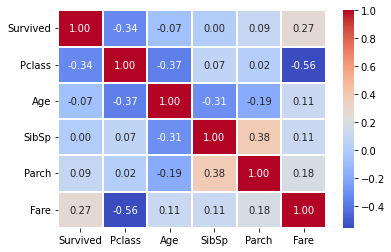

In [14]:
# Heatmap of the correlation of numeric columns
col = ["Survived" ,'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
corrmat = train[col].corr()
sns.heatmap(corrmat, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.1);

In [15]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,880.000000,880.000000,880.000000,710.000000,880.000000,880.000000,880.000000
mean,446.373864,0.386364,2.309091,29.674887,0.454545,0.362500,31.076249
std,256.564211,0.487192,0.834364,14.479217,0.871872,0.791998,48.004681
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,225.750000,0.000000,2.000000,20.125000,0.000000,0.000000,7.895800
50%,447.500000,0.000000,3.000000,28.000000,0.000000,0.000000,14.427100
75%,667.250000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


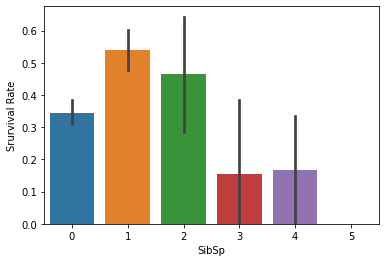

In [16]:
# SibSp
col = "SibSp"
sns.barplot(x=col, y="Survived", data=train)
plt.ylabel("Srurvival Rate");

<Axes: xlabel='Parch', ylabel='Survived'>

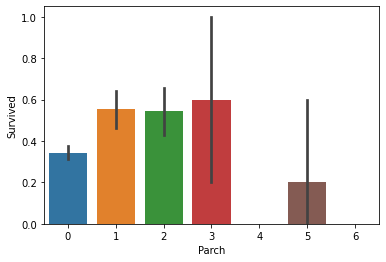

In [17]:
# Parch
sns.barplot(data=train, x="Parch", y="Survived")

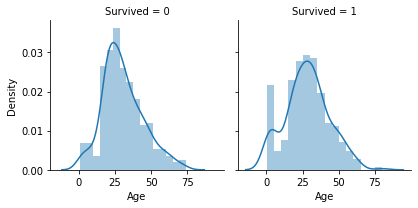

In [18]:
# Age
# 凡例ごとに分けてグラフを書くことができる　凡例＝Survived
g = sns.FacetGrid(train, col="Survived")
# Use map to draw it, using distplot
g = g.map(sns.distplot, "Age")

Skewness: 4.512689327210354


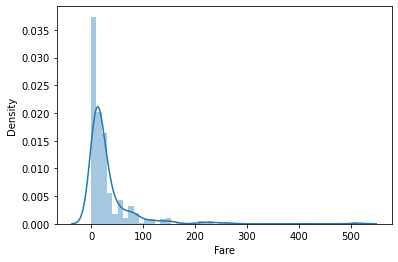

In [19]:
# Fare
sns.distplot(train["Fare"])
print("Skewness:",dataset["Fare"].skew())

In [20]:
dataset["Fare"] = np.log1p(dataset["Fare"])

Skewness: 0.5454503858334889


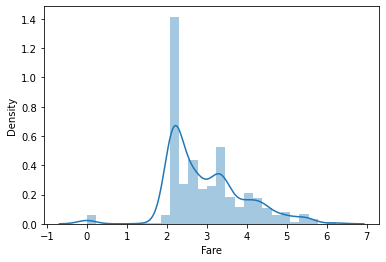

In [21]:
sns.distplot(dataset["Fare"])
print("Skewness:", dataset["Fare"].skew())

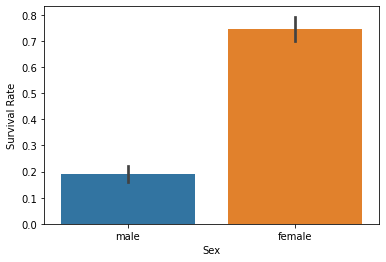

In [22]:
# Sex
sns.barplot(data=train, x="Sex", y="Survived");
plt.ylabel("Survival Rate");

In [23]:
train[["Sex", "Survived"]].groupby("Sex").mean()

,Survived
Sex,
female,0.747573
male,0.190893


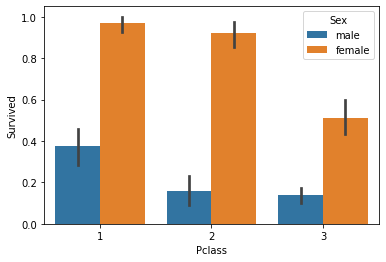

In [24]:
# Pclass
sns.barplot(data=train, x="Pclass", y="Survived", hue="Sex");

<Axes: xlabel='Embarked', ylabel='Survived'>

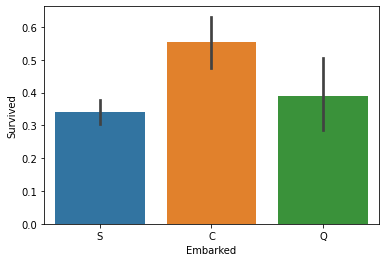

In [25]:
# Embarked
# The people from C have the highest survival rate
sns.barplot(data=train, x="Embarked", y="Survived")

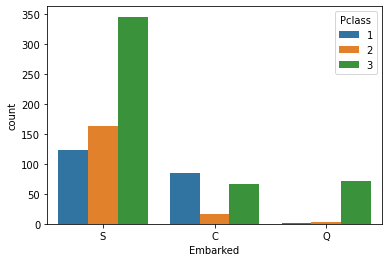

In [26]:
# The proportion of the 1st class is higher in C than in S and Q, so the survival rate is higher
sns.countplot(data=train, x="Embarked", hue="Pclass");

In [27]:
# Fill nan
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())
# Fill nan with "S" the most frequent value
dataset["Embarked"] = dataset["Embarked"].fillna("S")

In [28]:
dataset.isna().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1007
Embarked          0
dtype: int64

<Axes: xlabel='Sex', ylabel='Age'>

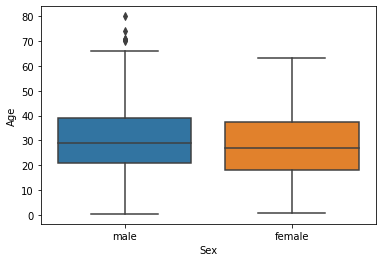

In [29]:
sns.boxplot(data=train, x="Sex", y="Age")


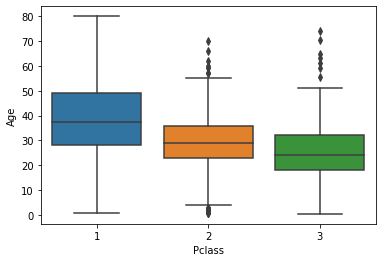

In [30]:
g=sns.boxplot(train, x ="Pclass", y="Age")

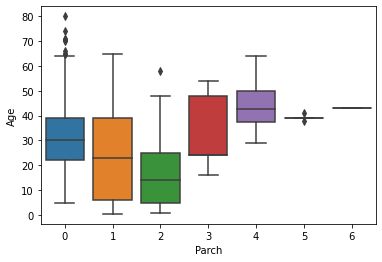

In [31]:
sns.boxplot(train, x="Parch", y="Age");

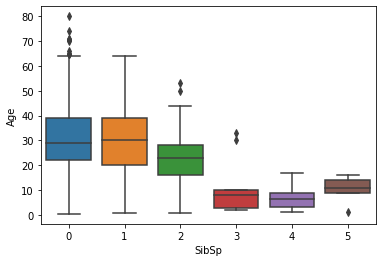

In [32]:
sns.boxplot(train, x="SibSp", y="Age");

<Axes: xlabel='Age', ylabel='Fare'>

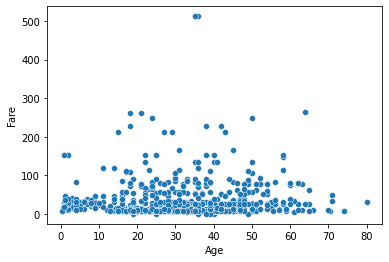

In [33]:
sns.scatterplot(data=train, x="Age", y="Fare")

In [34]:
# Fill nan in "Age" according to Pclass, Parch and SibSp
idx_nan = dataset[dataset["Age"].isna()].index
# the median of the age
med_age = dataset["Age"].median()

for idx in idx_nan:
    row = dataset.iloc[idx]
    # the median of the age of the people who have the same Pclass, Parch and SibSp
    pred_age = dataset[(dataset["Pclass"] == row["Pclass"]) & (dataset["Parch"] == row["Parch"]) & (dataset["SibSp"] == row["SibSp"])]["Age"].median()

    if not np.isnan(pred_age):
        dataset["Age"].iloc[idx] = pred_age
    else:
        dataset["Age"].iloc[idx] = med_age
    

In [35]:
dataset.describe(include="O")

,Name,Sex,Ticket,Cabin,Embarked
count,1298,1298,1298,291,1298
unique,1296,2,929,186,3
top,"Connolly, Miss. Kate",male,CA 2144,G6,S
freq,2,837,8,5,905


In [36]:
dataset = dataset.drop(["PassengerId", "Ticket", "Cabin", "Name"], axis=1)

In [37]:
dataset = pd.get_dummies(dataset)
dataset = dataset.drop(columns="Sex_male")

In [38]:
train = dataset[:train_len]
test = dataset[train_len:]
test = test.drop(columns="Survived")

In [39]:
train["Survived"] = train["Survived"].astype(int)
y_train = train["Survived"]
x_train = train.drop(columns="Survived")
x_test = test

In [40]:
n_splits = 5

def acc_cv(model):
    kf = KFold(n_splits, shuffle=True, random_state=42)
    cv = cross_validate(model, x_train, y_train, scoring="accuracy", cv=kf)   
    return cv["test_score"]

In [41]:
rlda = LinearDiscriminantAnalysis(shrinkage=0.1, solver="lsqr")
rlda = make_pipeline(RobustScaler(), rlda)

print("Mean accuracy of LDA:", acc_cv(rlda).mean())

Mean accuracy of LDA: 0.7897727272727273


In [42]:
clf = svm.SVC(C=1, gamma=0.1, kernel="rbf")
clf = make_pipeline(RobustScaler(), clf)

print("Mean accuracy of SVM:", acc_cv(clf).mean())

Mean accuracy of SVM: 0.8170454545454545


In [45]:
lgbm_params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'accuracy',
        'num_leaves': 8,
        "max_depth": 5,
        'learning_rate': 0.05,
        'n_estimators': 100,
        'random_state': 42,
        "class_weight": "balanced"
    }
lgbm = lgb.LGBMClassifier(**lgbm_params)
lgbm = make_pipeline(RobustScaler(), lgbm)

print("Mean accuracy of LGBM:", acc_cv(lgbm).mean())

Mean accuracy of LGBM: 0.8113636363636363


In [47]:
rlda_pred = rlda.fit(x_train, y_train).predict(x_test).astype(int)
svm_pred = clf.fit(x_train, y_train).predict(x_test).astype(int)
lgbm_pred = lgbm.fit(x_train, y_train).predict(x_test).astype(int)


In [54]:
# Ensemble
sum_pred = rlda_pred + svm_pred + lgbm_pred
ensemble_pred = (sum_pred >= 2).astype(int)
Id = test_raw["PassengerId"].astype(int)

In [59]:
reload(function)
function.save_kaggle_prediction(Id, ensemble_pred, "PassengerId", "Survived")